In [1]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

from tqdm import tqdm
from random import choices
import random

import seaborn as sns
import matplotlib.pyplot as plt
import kerastuner as kt
import os

In [2]:
def utility_score_bincount(date, weight, resp, action):
    count_i = len(np.unique(date))
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / count_i)
    u = np.clip(t, 0, 6) * np.sum(Pi)
    return u
    
class LiteModel:
    
    @classmethod
    def from_file(cls, model_path):
        return LiteModel(tf.lite.Interpreter(model_path=model_path))
    
    @classmethod
    def from_keras_model(cls, kmodel):
        converter = tf.lite.TFLiteConverter.from_keras_model(kmodel)
        tflite_model = converter.convert()
        return LiteModel(tf.lite.Interpreter(model_content=tflite_model))
    
    def __init__(self, interpreter):
        self.interpreter = interpreter
        self.interpreter.allocate_tensors()
        input_det = self.interpreter.get_input_details()[0]
        output_det = self.interpreter.get_output_details()[0]
        self.input_index = input_det["index"]
        self.output_index = output_det["index"]
        self.input_shape = input_det["shape"]
        self.output_shape = output_det["shape"]
        self.input_dtype = input_det["dtype"]
        self.output_dtype = output_det["dtype"]
        
    def predict(self, inp):
        inp = inp.astype(self.input_dtype)
        count = inp.shape[0]
        out = np.zeros((count, self.output_shape[1]), dtype=self.output_dtype)
        for i in range(count):
            self.interpreter.set_tensor(self.input_index, inp[i:i+1])
            self.interpreter.invoke()
            out[i] = self.interpreter.get_tensor(self.output_index)[0]
        return out
    
    def predict_single(self, inp):
        """ Like predict(), but only for a single record. The input data can be a Python list. """
        inp = np.array([inp], dtype=self.input_dtype)
        self.interpreter.set_tensor(self.input_index, inp)
        self.interpreter.invoke()
        out = self.interpreter.get_tensor(self.output_index)
        return out[0]

In [3]:
train = pd.read_csv('../input/jane-street-market-prediction/train.csv')
train = train.query('date > 90').reset_index(drop = True) 
train = train.astype({c: np.float32 for c in train.select_dtypes(include='float64').columns}) #limit memory use
train = train.query('weight > 0').reset_index(drop = True)
train.fillna(train.mean(),inplace=True)
features = [c for c in train.columns if 'feature' in c]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(train[features].values)
# X = train[features].values

y = (train['resp'] > 0).astype('int')
f_mean = np.mean(train[features[1:]].values,axis=0)

In [4]:
## v1
def create_autoencoder(input_dim,output_dim,noise=0.05):
    i = Input(input_dim)
    encoded = BatchNormalization()(i)
    encoded = GaussianNoise(noise)(encoded)
    encoded = Dense(256,activation='sigmoid')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Dense(256,activation='sigmoid')(encoded)
    
    decoded = BatchNormalization()(encoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(256,activation='sigmoid')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(input_dim,activation='sigmoid',name='decoded')(decoded)
    
    x = Dense(256)(decoded)
    x = BatchNormalization()(x)
    x = Lambda(tf.keras.activations.swish)(x)
    x = Dropout(0.2)(x)
    x = Dense(output_dim,activation='sigmoid',name='label_output')(x)
    
    encoder = Model(inputs=i,outputs=decoded)
    autoencoder = Model(inputs=i,outputs=[decoded,x])
    
    autoencoder.compile(optimizer=Adam(0.01),loss={'decoded':'mse','label_output':'mse'})
    return autoencoder, encoder

def create_model(hp,input_dim,output_dim,encoder):
    inputs = Input(input_dim)
    
    x = encoder(inputs)
    x = Concatenate()([x,inputs]) #use both raw and de-noised features
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('init_dropout',0.0,0.5))(x)
    
    for i in range(hp.Int('num_layers',1,3)):
        x = Dense(hp.Int('num_units_{i}',64,256))(x)
        x = BatchNormalization()(x)
        x = Lambda(tf.keras.activations.swish)(x)
        x = Dropout(hp.Float(f'dropout_{i}',0.0,0.5))(x)
    x = Dense(output_dim,activation='sigmoid')(x)
    model = Model(inputs=inputs,outputs=x)
    model.compile(optimizer=Adam(hp.Fixed('lr',0.01)),loss=BinaryCrossentropy(label_smoothing=hp.Float('label_smoothing',0.0,0.1)),metrics=[tf.keras.metrics.AUC(name = 'auc')])
    return model

In [5]:
# %%time
# SEEDS = [2000, 5000]
# FOLDS = 5
# models = []
# for SEED in SEEDS:
#     _, encoder = create_autoencoder(X.shape[-1],1,noise=0.1)
#     encoder.load_weights(f'../input/jane-street-models-v1/encoder_{SEED}.hdf5')
#     model_fn = lambda hp: create_model(hp,X.shape[-1],1,encoder)
#     hp = pd.read_pickle(f'../input/bottleneck-encoder-mlp-keras-tuner/best_hp_{SEED}.pkl')
#     for f in range(FOLDS):
#         model = model_fn(hp)
#         model.load_weights(f'../input/bottleneck-encoder-mlp-keras-tuner/model_{SEED}_{f}_finetune.hdf5')
#         model = LiteModel.from_keras_model(model)
#         models.append(model)

In [6]:
## v2
def create_autoencoder(input_dim,output_dim,noise=0.05):
    i = Input(input_dim)
    encoded = BatchNormalization()(i)
    encoded = GaussianNoise(noise)(encoded)
    encoded = Dense(800,activation='relu')(encoded)
    decoded = Dropout(0.5)(encoded)
    decoded = Dense(input_dim,name='decoded')(decoded)
    x = Dense(320,activation='relu')(decoded)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(output_dim,activation='sigmoid',name='label_output')(x)
    
    encoder = Model(inputs=i,outputs=encoded)
    autoencoder = Model(inputs=i,outputs=[decoded,x])
    
    autoencoder.compile(optimizer=Adam(0.001),loss={'decoded':'mse','label_output':'binary_crossentropy'})
    return autoencoder, encoder

def create_model(hp,input_dim,output_dim,encoder):
    inputs = Input(input_dim)
    
    x = encoder(inputs)
    x = Concatenate()([x,inputs]) #use both raw and de-noised features
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('init_dropout',0.1,0.5))(x)
    
    for i in range(hp.Int('num_layers',1,3)):
        x = Dense(hp.Int(f'num_units_{i}',100,300))(x)
        x = BatchNormalization()(x)
        x = Lambda(tf.keras.activations.swish)(x)
        x = Dropout(hp.Float(f'dropout_{i}',0.1,0.5))(x)
    x = Dense(output_dim,activation='sigmoid')(x)
    model = Model(inputs=inputs,outputs=x)
    model.compile(optimizer=Adam(hp.Fixed('lr',0.01)),loss=BinaryCrossentropy(label_smoothing=hp.Float('label_smoothing',0.0,0.1)),metrics=[tf.keras.metrics.AUC(name = 'auc')])
    return model

In [7]:
%%time
SEEDS = [5, 10, 15, 20]
FOLDS = 5
models = []
for SEED in SEEDS:
    _, encoder = create_autoencoder(X.shape[-1],1,noise=0.1)
    encoder.load_weights(f'../input/jane-street-models-v2/encoder_{SEED}.hdf5')
    model_fn = lambda hp: create_model(hp,X.shape[-1],1,encoder)
    hp = pd.read_pickle(f'../input/jane-street-models-v2/best_hp_{SEED}.pkl')
    for f in range(FOLDS):
        model = model_fn(hp)
        model.load_weights(f'../input/jane-street-models-v2/model_{SEED}_{f}_finetune.hdf5')
        model = LiteModel.from_keras_model(model)
        models.append(model)

CPU times: user 1min 31s, sys: 1.13 s, total: 1min 32s
Wall time: 1min 37s


## Submission

In [8]:
import janestreet
# f = lambda x: np.sum(np.around(x))/len(models) #Majority voting
#janestreet.competition.make_env.__called__ = False
env = janestreet.make_env()
th = 0.5
for (test_df, pred_df) in tqdm(env.iter_test()):
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, features].values
        if np.isnan(x_tt[:, 1:].sum()):
            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        pred = np.mean([model.predict(scaler.transform(x_tt)) for model in models], axis=0)
        pred = np.mean(pred)
        pred_df.action = np.where(pred > th, 1, 0).astype(int)
    else:
        pred_df.action = 0
    env.predict(pred_df)

15219it [04:49, 52.62it/s]


In [9]:
submission = pd.read_csv('./submission.csv')
submission.head()

,ts_id,action
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


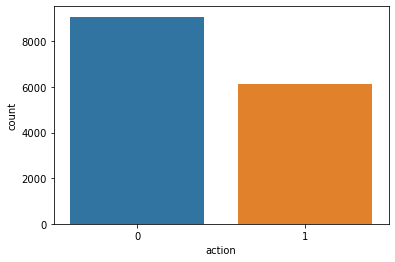

In [10]:
sns.countplot(submission.action);